In [1]:
# Third-party and Standard Libraries
from datetime import datetime
import numpy as np
import torch
import time
import os

# Modules
from KG_test import gpt_test, gpt_test_loss, pinn_test, pinn_test_loss
from KG_precompute import inputs, gram_schmidt1, gram_schmidt2
from KG_train import pinn_train, offline_generation_bic
from KG_data import residual_data, ICBC_data
from KG_precompute import xcos_term
from KG_models import NN

data_dir = "./kg_data"
if (os.path.exists(data_dir) == False):
    os.makedirs(data_dir)

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda")
print_seperator = 60*"*"

sparse = False

if (sparse):
    ext = "bic_s"
else:
    ext = ""

print(f"Start: {datetime.now()}\n")

###############################################################################
#### Domain and simulated data ####
Xi, Xf         = -1.0, 1.0
Ti, Tf         =  0.0, 5.0
Nc, N_test     =  100,  40
BC_pts, IC_pts =  512, 512

xt_resid, f_hat, xt_test = residual_data(Xi, Xf, Ti, Tf, Nc, N_test)
xt_resid = xt_resid.to(device)
f_hat    = f_hat.to(device)
xt_test  = xt_test.to(device) 

IC_xt, IC_u1, IC_u2, BC_xt, BC_u = ICBC_data(Xi, Xf, Ti, Tf, BC_pts, IC_pts) 
IC_xt = IC_xt.to(device)
IC_u1 = IC_u1.to(device)
IC_u2 = IC_u2.to(device)
BC_xt = BC_xt.to(device)
BC_u  = BC_u.to(device)    

#### Training parameter set ####
alpha    = np.linspace(-2, -1, 10)
beta     = np.linspace( 0,  1, 10)
gamma    = np.linspace( 0,  1, 10) 
kg_train = np.array(np.meshgrid(alpha, beta, gamma)).T.reshape(-1,3)
kg_train_all = kg_train.copy() 

#### Forcing function ####
xcos_x2cos2 = xcos_term(xt_resid[:,0].unsqueeze(1), 
                        xt_resid[:,1].unsqueeze(1))

#### PINN Attributes ####
layers_pinn = np.array([2, 40, 40, 1])
lr_pinn     = 0.0005
epochs_pinn = 75000#100000

#### GPT-PINN attributes ####
number_of_neurons = 12
if (sparse):
    lr_gpt = 0.0025
else:
    lr_gpt = 0.0025
epochs_gpt_train  = 2000

test_cases      = np.ceil(0.2*len(kg_train)).astype(int)
epochs_gpt_test = 5000

loss_list  = np.zeros(number_of_neurons)
neurons    = np.zeros((number_of_neurons,3))

# Two kinds of initializations for the neurons
neurons[0] = (np.median(alpha), np.median(beta), np.median(gamma))
#neurond[0] = kg_train[np.random.randint(low=0, high=len(kg_train))]

c_init = np.zeros(number_of_neurons, dtype=object)
for i in range(number_of_neurons):
    c_init[i] = torch.full((1,i+1), 1/(i+1)).to(device)

#### Data sizes ####
test_size = xt_test.shape[0]
xt_size   = xt_resid.shape[0]
IC_size   = IC_xt.shape[0]
BC_size   = BC_xt.shape[0]

if (sparse):
    #### Training point data ####
    X_train_all   = torch.zeros((2*number_of_neurons-1,2)).to(device)
    X_all_idx     = torch.zeros( 2*number_of_neurons-1, dtype=torch.long).to(device)
    X_umax_idx    = torch.zeros(   number_of_neurons,   dtype=torch.long).to(device)
    X_rmax_idx    = torch.zeros(   number_of_neurons-1, dtype=torch.long).to(device)
    residual_full = torch.zeros((xt_size, number_of_neurons-1)).to(device)

#### Neuron outputs on the full training grid ####
xt_resid      = xt_resid.requires_grad_()
IC_xt         = IC_xt.requires_grad_()
out_full      = torch.zeros((xt_size, number_of_neurons)).to(device) 
out_xx_full   = torch.zeros((xt_size, number_of_neurons)).to(device) 
out_tt_full   = torch.zeros((xt_size, number_of_neurons)).to(device) 
out_BC        = torch.zeros((BC_size, number_of_neurons)).to(device)
out_IC        = torch.zeros((IC_size, number_of_neurons)).to(device)
out_IC_t      = torch.zeros((IC_size, number_of_neurons)).to(device)

#### Neuron outputs on the test grid ####
out_test = torch.zeros((test_size, number_of_neurons)).to(device) 
L_hat = torch.zeros(number_of_neurons,1).to(device)

Start: 2024-12-31 05:57:02.423173



In [2]:
generation_time = np.zeros(number_of_neurons)

###############################################################################
total_time_1 = time.time()
for i, neuron in enumerate(neurons):
    print(print_seperator)
    
    # Don't need to train over parameters already used as neurons
    kg_train = np.delete(kg_train, np.where(np.all(kg_train == neuron, 
                                                   axis=1))[0], axis=0)
    ###########################################################################
    # PINN to be used as activation function  
    alpha, beta, gamma = neuron
    t1 = time.time()
    PINN = NN(layers_pinn, alpha, beta, gamma, xcos_x2cos2).to(device)
    pinn_train(PINN, alpha, beta, gamma, xt_resid, IC_xt, IC_u1, IC_u2, BC_xt, 
               BC_u, f_hat, epochs_pinn, lr_pinn)
    t2 = time.time()
    print(f"PINN time: {(t2-t1)/60} minutes\n")
    ###########################################################################
    # (S)GPT-PINN Training / Offline Generation    
    c_initial  = c_init[i][0]

    if (sparse): # SGPT
        train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, \
        train_out_BC, fhat, train_xcos, xt_len,ALPHA,Lhat = gram_schmidt1(PINN, i, xt_resid, 
        IC_xt, BC_xt, out_full, out_xx_full, out_tt_full, out_IC, out_IC_t, out_BC, 
        xcos_x2cos2, X_umax_idx, X_all_idx, X_train_all, xt_test, out_test, f_hat,L_hat)
        
    else: # GPT
        train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, \
        train_out_BC, fhat, train_xcos, xt_len = inputs(PINN, xt_resid, out_full, 
        out_xx_full, out_tt_full, out_IC_t, out_IC, out_BC, IC_xt, BC_xt, i, 
        out_test, xt_test, f_hat, xcos_x2cos2, xt_size)
    
    t1 = time.time()
    largest_loss, largest_case, trained_c = offline_generation_bic(kg_train, 
    c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, 
    train_out_BC, fhat, epochs_gpt_train, lr_gpt)                                                       
    t2 = time.time()
    
    generation_time[i] = (t2-t1)/60
    print(f"Generation time: {(t2-t1)/60} minutes") 
                                                        
    ###########################################################################
    loss_list[i] = largest_loss
    
    if (i+1 < number_of_neurons):
        neurons[i+1] = largest_case
        
    print(f"\nLargest Loss (Using {i+1} Neurons): {largest_loss}")
    print(f"Parameter Case: {largest_case}\n")
        
    if (i == number_of_neurons-1):
        break
    
    ###########################################################################
    if (sparse):
        alpha, beta, gamma = largest_case
        gram_schmidt2(i, xt_resid, alpha, beta, gamma, trained_c, residual_full, 
                      out_full, out_xx_full, out_tt_full, xcos_x2cos2, X_rmax_idx, 
                      X_all_idx, X_train_all)
        
total_time = (time.time() - total_time_1) / 3600

print(print_seperator)
print(f"Total Training Time: {total_time} Hours\n")
print(f"Activation Function Parameters: \n{neurons}\n")
print(f"Loss list: {loss_list}\n")

************************************************************


/dssg/home/acct-matxzl/matxzl/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


PINN Final Loss: 4.493467713473365e-05
PINN time: 4.465356246630351 minutes

Generation time: 0.17724657853444417 minutes

Largest Loss (Using 1 Neurons): 0.2250535786151886
Parameter Case: (-1.0, 1.0, 0.0)

************************************************************
PINN Final Loss: 4.573792830342427e-05
PINN time: 4.44433813492457 minutes

Generation time: 1.67043403784434 minutes

Largest Loss (Using 2 Neurons): 0.0871308296918869
Parameter Case: (-2.0, 0.0, 0.0)

************************************************************
PINN Final Loss: 0.00011102270218543708
PINN time: 4.443072243531545 minutes

Generation time: 1.2499614000320434 minutes

Largest Loss (Using 3 Neurons): 0.051663126796483994
Parameter Case: (-2.0, 1.0, 1.0)

************************************************************
PINN Final Loss: 0.00011855245247716084
PINN time: 4.462973435719808 minutes

Generation time: 0.9248084704081218 minutes

Largest Loss (Using 4 Neurons): 0.038165099918842316
Parameter Case: (-1

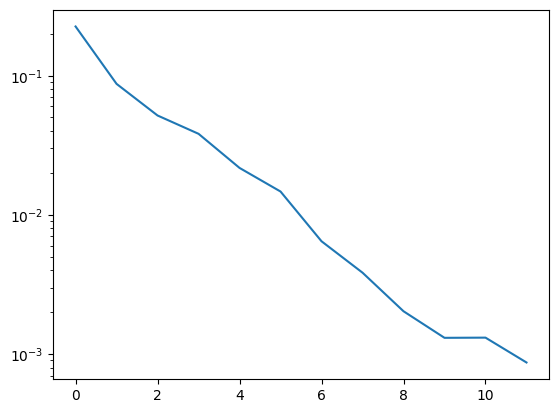

In [3]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.yscale('log')

In [4]:
print({stop})

NameError: name 'stop' is not defined

In [5]:
#kg_test = kg_train[np.random.choice(len(kg_train), test_cases, replace=False)]
kg_test = np.loadtxt(data_dir + "/kg_test.dat")
pinn_test_soln = np.loadtxt(data_dir+"/test_pinn_soln.dat")

from KG_test import gpt_test_bic,gpt_test_loss_bic
print(f"{ext.upper()}GPT-PINN Testing Started")
test_gpt_time, test_gpt_soln = gpt_test_bic(kg_test,c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, 
    train_out_BC, fhat, epochs_gpt_train, lr_gpt,out_test,None)

test_gpt_losses = gpt_test_loss_bic(kg_test,c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, 
    train_out_BC, fhat, epochs_gpt_train, lr_gpt,None)
print(f"{ext.upper()}GPT-PINN Testing Ended\n")

GPT-PINN Testing Started
GPT-PINN Testing Ended



In [9]:
np.savetxt(data_dir+f"/{ext}gpt_generation_time.dat",  generation_time)
np.savetxt(data_dir+f"/{ext}gpt_loss_list.dat",        loss_list)
np.savetxt(data_dir+f"/{ext}gpt_neurons.dat",          neurons)
np.savetxt(data_dir+f"/{ext}gpt_total_time.dat",       np.array([total_time]))

np.savetxt(data_dir+"/xt_resid.dat",         xt_resid.detach().cpu().numpy())
if (sparse):
    np.savetxt(data_dir+"/X_train_all.dat",  X_train_all.cpu().numpy())
    np.savetxt(data_dir+"/X_all_idx.dat",    X_all_idx.cpu().numpy())
    np.savetxt(data_dir+"/X_umax_idx.dat",   X_umax_idx.cpu().numpy())
    np.savetxt(data_dir+"/X_rmax_idx.dat",   X_rmax_idx.cpu().numpy())

np.savetxt(data_dir+"/kg_train_all.dat",     kg_train_all)
np.savetxt(data_dir+"/kg_test.dat",          kg_test)
np.savetxt(data_dir+"/xt_test.dat",          xt_test.cpu().numpy())

np.savetxt(data_dir+f"/test_{ext}gpt_losses.dat", test_gpt_losses)
np.savetxt(data_dir+f"/test_{ext}gpt_soln.dat",   test_gpt_soln)
np.savetxt(data_dir+f"/test_{ext}gpt_time.dat",   test_gpt_time+total_time)

#np.savetxt(data_dir+"/test_pinn_losses.dat", test_losses_pinn)
#np.savetxt(data_dir+"/test_pinn_soln.dat",   test_pinn_soln)
#np.savetxt(data_dir+"/test_pinn_time.dat",   test_pinn_time)

params = {"device":device,
          "domain": {"xi":Xi, "xf":Xf, "ti":Ti, "tf":Tf}, 
          "data sizes": {"Nc":Nc, "N_test":N_test, "BC_pts":BC_pts, "IC_pts":IC_pts},
          "layers pinn":layers_pinn,
          "lr pinn":lr_pinn,
          "epochs pinn":epochs_pinn,
          "parameter size":len(kg_train_all),
          "number of neurons":number_of_neurons,
          f"lr {ext}gpt":lr_gpt,
          f"epochs {ext}gpt train":epochs_gpt_train,
          "test cases":test_cases,
          f"epochs {ext}gpt test":epochs_gpt_test,
          "sparse":sparse,
          "seed":seed}

np.save(data_dir+"/params_gpt_bic_adam.npy", params) 

In [8]:
variables = {
    "kg_test": kg_test,
    "c_initial": c_initial,
    "xt_len": xt_len,
    "IC_size": IC_size,
    "BC_size": BC_size,
    "IC_u1": IC_u1,
    "IC_u2": IC_u2,
    "BC_u": BC_u,
    "train_xcos": train_xcos,
    "train_out": train_out,
    "train_out_xx": train_out_xx,
    "train_out_tt": train_out_tt,
    "train_out_IC": train_out_IC,
    "train_out_IC_t": train_out_IC_t,
    "train_out_BC": train_out_BC,
    "fhat": fhat,
    "epochs_gpt_train": epochs_gpt_train,
    "lr_gpt": lr_gpt,
    "out_test": out_test
}

torch.save(variables,data_dir+"/variables_gpt_bic_adam.npy") 